In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
import glob

from fbprophet import Prophet
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
from datetime import datetime, timedelta

In [2]:
df=pd.read_csv('pm2.5.csv')

In [3]:
df

,date,Year,Month,Day,Hour,NowCast Conc.,AQI,Raw Conc.
0,1/3/16 3:00,2016,3,1,3,251.4,302.0,289.0
1,1/3/16 4:00,2016,3,1,4,246.0,296.0,240.0
2,1/3/16 5:00,2016,3,1,5,264.0,314.0,290.0
3,1/3/16 6:00,2016,3,1,6,256.8,307.0,245.0
4,1/3/16 7:00,2016,3,1,7,238.2,288.0,205.0
...,...,...,...,...,...,...,...,...
30744,30/11/19 20:00,2019,11,30,20,143.9,197.0,176.0
30745,30/11/19 21:00,2019,11,30,21,176.4,227.0,209.0
30746,30/11/19 22:00,2019,11,30,22,201.2,251.0,226.0
30747,30/11/19 23:00,2019,11,30,23,202.6,253.0,204.0


In [4]:
frame=df

In [5]:
frame.shape

(30749, 8)

In [6]:
frame['NowCast Conc.'].fillna(frame['NowCast Conc.'].median(), inplace=True)
frame['AQI'].fillna(frame['AQI'].median(), inplace=True)

frame['Raw Conc.'].fillna(frame['Raw Conc.'].median(), inplace=True)

In [7]:
# percentage of missing values in each column
round(frame.isnull().sum()/len(frame.index), 2)*100

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


date             0.0
Year             0.0
Month            0.0
Day              0.0
Hour             0.0
NowCast Conc.    0.0
AQI              0.0
Raw Conc.        0.0
dtype: float64

In [10]:
df_2019 = frame[frame['Year']==2019]

In [11]:
df_2019.head()

,date,Year,Month,Day,Hour,NowCast Conc.,AQI,Raw Conc.
22839,1/1/19 0:00,2019,1,1,0,185.3,235.0,179.0
22840,1/1/19 1:00,2019,1,1,1,173.1,223.0,161.0
22841,1/1/19 2:00,2019,1,1,2,160.6,211.0,148.0
22842,1/1/19 3:00,2019,1,1,3,169.8,220.0,179.0
22843,1/1/19 4:00,2019,1,1,4,174.9,225.0,180.0


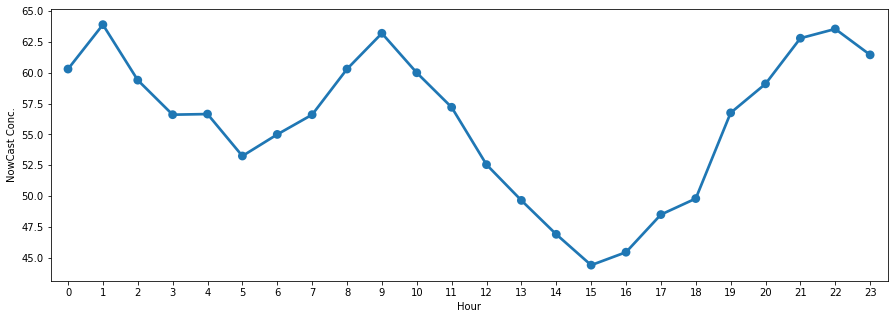

In [12]:
df = df_2019[['NowCast Conc.','Hour']].groupby(["Hour"]).median().reset_index().sort_values(by='Hour',ascending=False)
f,ax=plt.subplots(figsize=(15,5))
sns.pointplot(x='Hour', y='NowCast Conc.', data=df)

In [13]:
# creating date field for further analysis by extracting day of the week, month etc.
df_2019['date']=pd.to_datetime(df_2019[['Year', 'Month', 'Day']])

/Users/hridoy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# function to find day of the week based on the date field
import calendar
def findDay(date): 
    dayname = calendar.day_name[date.weekday()]
    return dayname

In [16]:
df_2019['day_week'] = df_2019['date'].apply(lambda x: findDay(x))
df_2019.head()

/Users/hridoy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,Year,Month,Day,Hour,NowCast Conc.,AQI,Raw Conc.,day_week
22839,2019-01-01,2019,1,1,0,185.3,235.0,179.0,Tuesday
22840,2019-01-01,2019,1,1,1,173.1,223.0,161.0,Tuesday
22841,2019-01-01,2019,1,1,2,160.6,211.0,148.0,Tuesday
22842,2019-01-01,2019,1,1,3,169.8,220.0,179.0,Tuesday
22843,2019-01-01,2019,1,1,4,174.9,225.0,180.0,Tuesday


In [17]:
custom_day = {'Monday':0, 'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

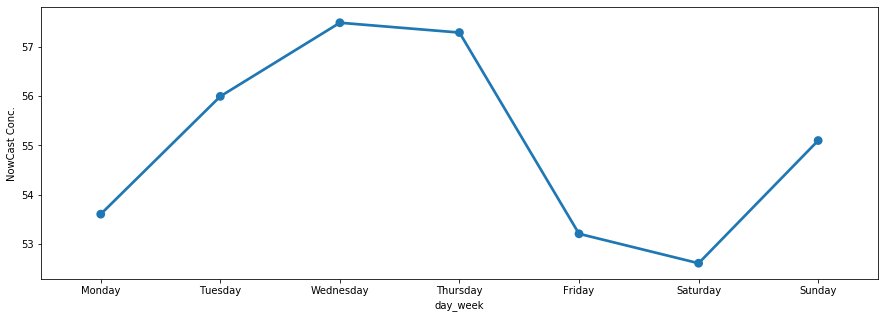

In [19]:
df = df_2019[['NowCast Conc.','day_week']].groupby(["day_week"]).median().reset_index().sort_values(by='day_week',ascending=True)
df = df.iloc[df['day_week'].map(custom_day).argsort()]
f,ax=plt.subplots(figsize=(15,5))
sns.pointplot(x='day_week', y='NowCast Conc.', data=df)

In [20]:
frame.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], inplace=True)

In [21]:
frame['Month'].value_counts()

Jul    2960
Mar    2959
May    2907
Nov    2870
Jun    2864
Apr    2786
Aug    2652
Dec    2208
Oct    2200
Sep    2180
Jan    2147
Feb    2016
Name: Month, dtype: int64

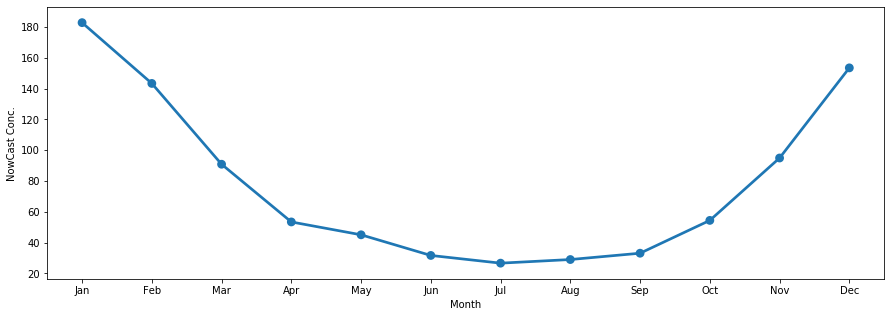

In [22]:
custom_dict = {'Jan':0, 'Feb':1,'Mar':2,'Apr':3,'May':4,'Jun':5,'Jul':6,'Aug':7,'Sep':8,'Oct':9,'Nov':10,'Dec':11}
df = frame[['NowCast Conc.','Month']].groupby(["Month"]).median().reset_index().sort_values(by='Month',ascending=True)
df = df.iloc[df['Month'].map(custom_dict).argsort()]
f,ax=plt.subplots(figsize=(15,5))
sns.pointplot(x='Month', y='NowCast Conc.', data=df)